<a href="https://colab.research.google.com/github/utkarsh0702/Pytorch/blob/master/PyTorch4_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
#Pre trained model VGG19 features
vgg= models.vgg19(pretrained=True).features

#freezing the parameters
for param in vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [3]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
def load_images(img_path, max_size=400, shape=None):
  image= Image.open(img_path).convert('RGB')
  if max(image.size)> max_size:
    size= max_size
  else:
    size= max(image.size)
  if shape is not None:
    size= shape
  
  transform= transforms.Compose([
                                 transforms.Resize(size),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
  ])
  image= transform(image)[:3,:,:].unsqueeze(0)
  return image

In [0]:
#load style and content image
content= load_images("content_image.jpg").to(device)
style= load_images("style_image.jpg", shape= content.shape[-2:]).to(device)

def im_convert(tensor):
  image= tensor.to('cpu').clone().detach()
  image= image.numpy().squeeze()
  image= image.transpose(1,2,0)
  image= image*np.array((0.229,0.224,0.225)) + np.array((0.485,0.456,0.406))
  image= image.clip(0,1)
  return image

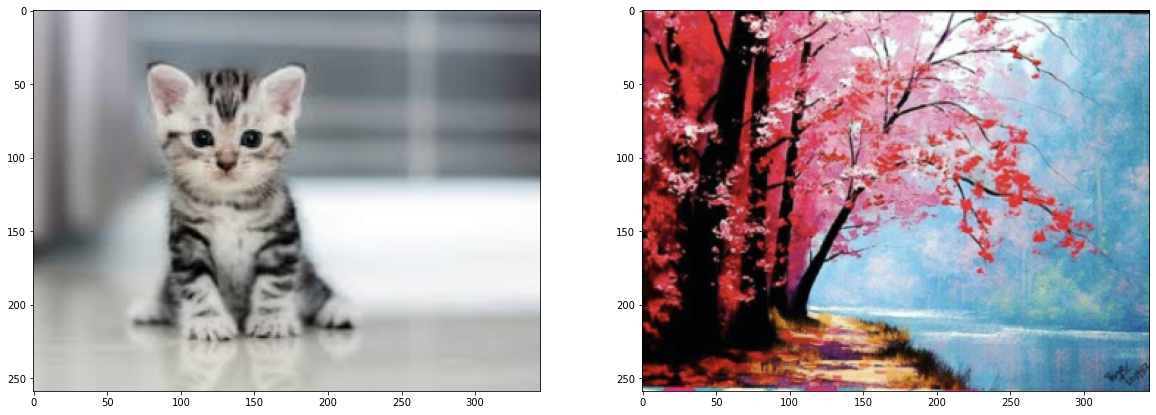

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
def get_features(image, model, layers=None):
  if layers is None:
    layers={'0':'conv1_1', '5':'conv2_1', '10':'conv3_1', '19':'conv4_1', '21':'conv4_2', '28':'conv5_1'}
  
  features={}
  x= image
  for name, layer in model._modules.items():
    x= layer(x)
    if name in layers:
      features[layers[name]]=x
  return features

In [0]:
#defining the gram matrix
def gram_matrix(tensor):
  _,d,h,w= tensor.size()
  tensor= tensor.view(d, h*w)
  gram= torch.mm(tensor, tensor.t())
  return gram

content_features= get_features(content, vgg)
style_features= get_features(style, vgg)

style_grams={layers: gram_matrix(style_features[layers]) for layers in style_features}
target= content.clone().requires_grad_(True). to(device)

style_weights={'conv1_1':0.9, 'conv2_1':0.8, 'conv3_1':0.2, 'conv4_1':0.1, 'conv5_1':0.1}

Total Loss: 113791.3515625


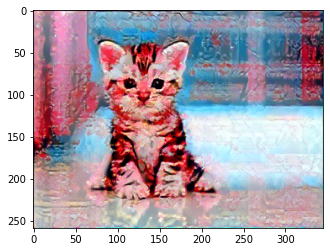

Total Loss: 51352.52734375


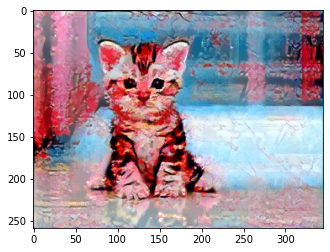

Total Loss: 33542.58203125


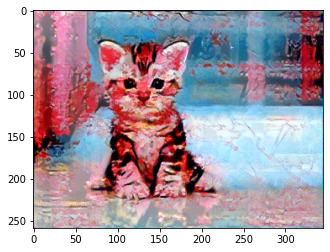

Total Loss: 24592.7578125


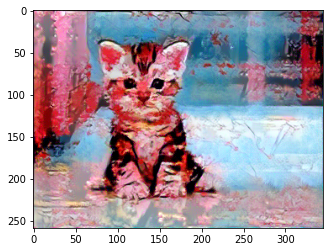

Total Loss: 18887.748046875


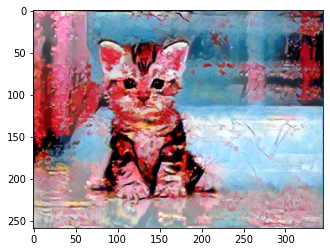

Total Loss: 15017.2021484375


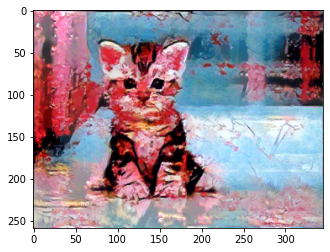

Total Loss: 12464.5


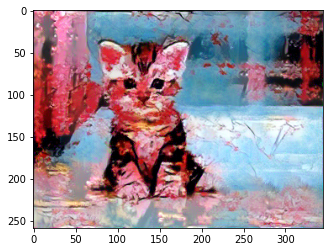

Total Loss: 10288.216796875


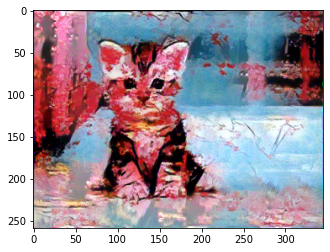

Total Loss: 8968.296875


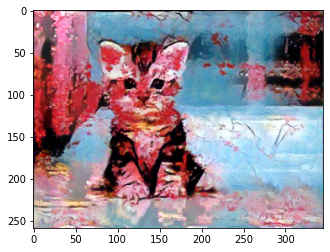

Total Loss: 8308.119140625


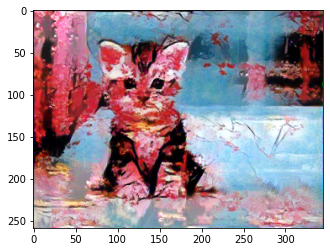

In [23]:
content_weight= 1
style_weight= 1e5
show_every=400
optimizer= optim.Adam([target], lr=0.03)
steps= 4000

for i in range(1, steps+1):
  target_features= get_features(target, vgg)
  content_loss= torch.mean((target_features['conv4_2']- content_features['conv4_2'])**2)
  style_loss=0
  for layer in style_weights:
    target_feature= target_features[layer]
    target_gram= gram_matrix(target_feature)
    _,d,h,w= target_feature.shape
    style_gram= style_grams[layer]
    layer_style_loss= style_weights[layer]*torch.mean((target_gram- style_gram)**2)
    style_loss+= layer_style_loss/(d*h*w)
  
  total_loss= content_weight*content_loss + style_weight*style_loss
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if (i % show_every) == 0:
    print('Total Loss:', total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()

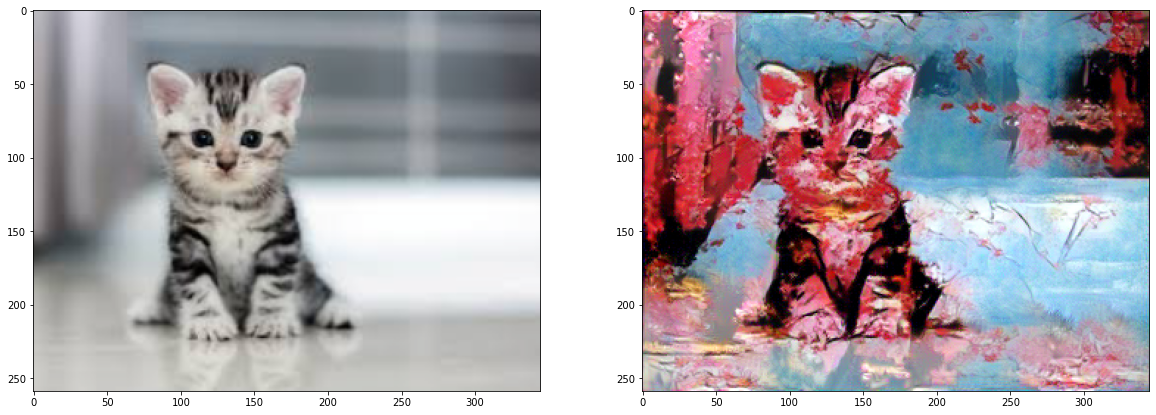

In [24]:
#Display the target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

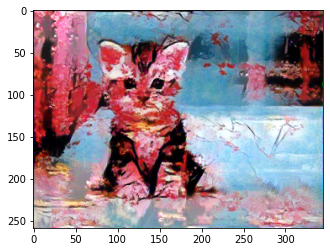

In [25]:
#Save the image
plt.imshow(im_convert(target))
plt.savefig('Photos.png', dpi=300, bbox_inches='tight')
plt.show()